# Step 1: Load Libraries

In [1]:
# Import required libraries
import pandas as pd
import pickle
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
logging.getLogger('werkzeug').setLevel(logging.ERROR)
logging.getLogger('google.colab._debugpy_repr').setLevel(logging.CRITICAL)
import gradio as gr
import joblib
import warnings
warnings.filterwarnings("ignore")


# Step 2: Load the Dataset
We used **fetch_california_housing** from scikit-learn to load the dataset directly into Pandas DataFrames for easy manipulation. The dataset contains 20,640 rows and 8 numerical features, with the target variable being median house value (scaled in $100,000s).





In [2]:
#  Load California Housing dataset
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
print(" Dataset Loaded")
X.head()

 Dataset Loaded


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


# Step 3: Data Exploration


In [3]:
# Quick overview
X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


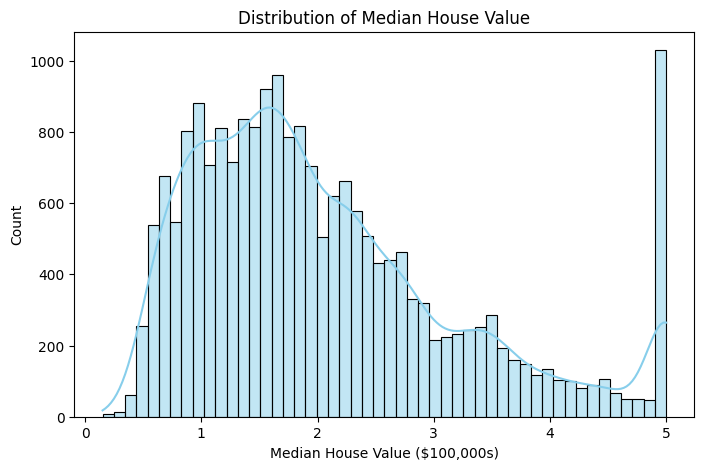

In [4]:
#  Histogram of Median House Value (target)
plt.figure(figsize=(8, 5))
sns.histplot(y, bins=50, kde=True, color="skyblue")
plt.title("Distribution of Median House Value")
plt.xlabel("Median House Value ($100,000s)")
plt.ylabel("Count")
plt.show()


This histogram shows the distribution of median house values from the California Housing dataset.
The data is right-skewed, meaning most housing areas have lower median values (peaking around $150k - $200k), with fewer areas having very high values.
The most important feature is the large spike at the maximum value of 5($500,000). This is not natural; it's because the data was capped. Any property with a median value of $500,000 or more was simply recorded as $500,000. This is a critical limitation to be aware of when using this dataset for analysis or machine learning.

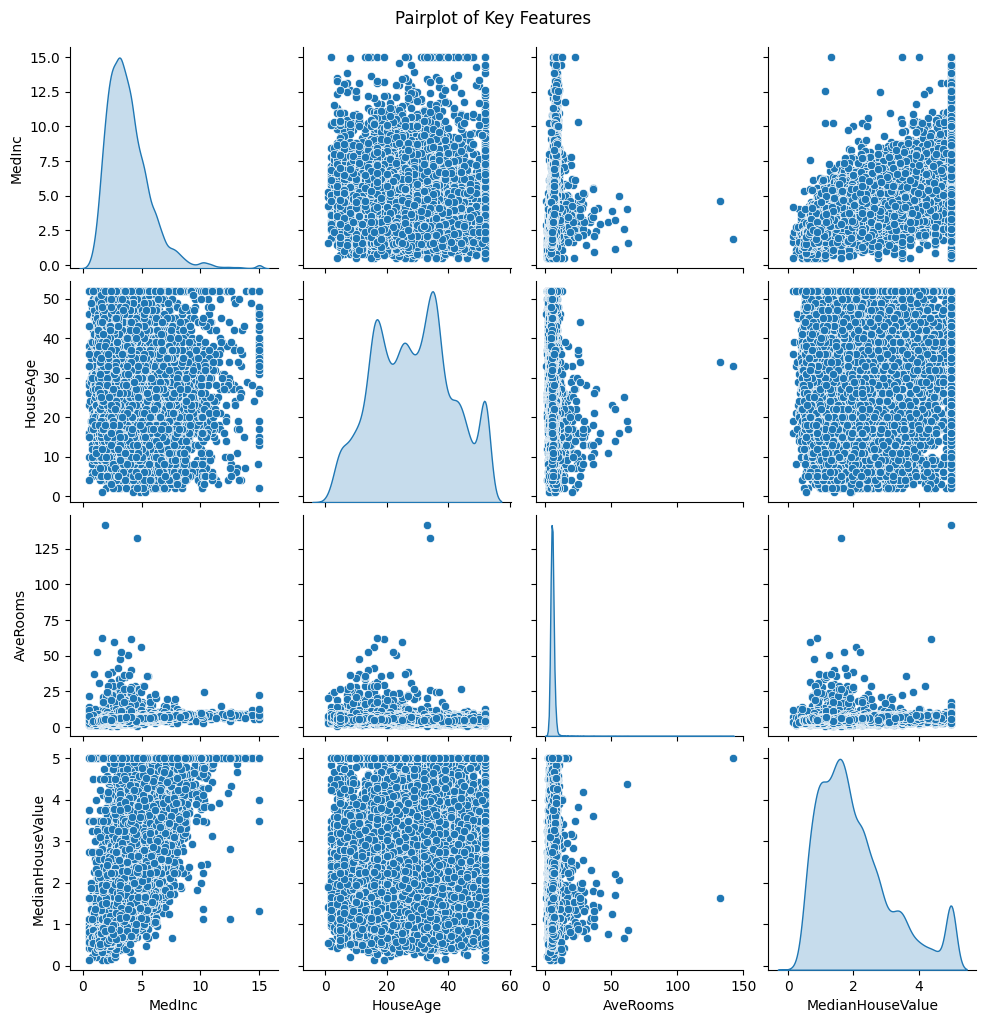

In [5]:
# Pairplot of Selected Features
sample_df = X.copy()
sample_df['MedianHouseValue'] = y
sns.pairplot(sample_df[['MedInc', 'HouseAge', 'AveRooms', 'MedianHouseValue']], diag_kind='kde')
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()


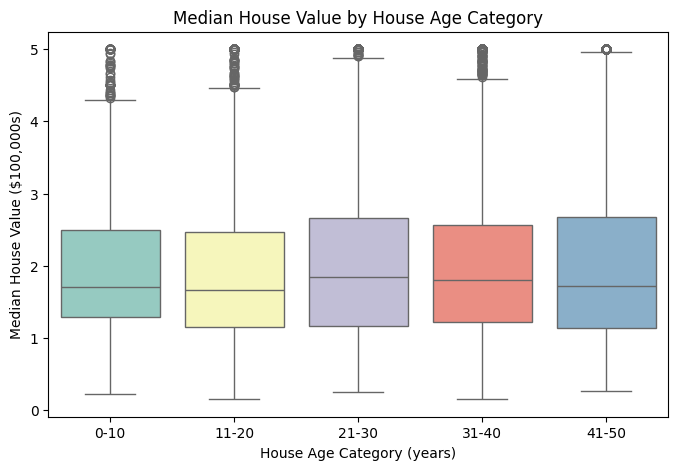

In [6]:
sample_df['HouseAgeCat'] = pd.cut(sample_df['HouseAge'], bins=[0, 10, 20, 30, 40, 50], labels=["0-10", "11-20", "21-30", "31-40", "41-50"])
plt.figure(figsize=(8, 5))
sns.boxplot(x='HouseAgeCat', y='MedianHouseValue', data=sample_df, palette="Set3")
plt.title("Median House Value by House Age Category")
plt.xlabel("House Age Category (years)")
plt.ylabel("Median House Value ($100,000s)")
plt.show()


This boxplot shows the relationship between house age (grouped into 10-year categories) and median house value (in $100,000s).

We can see that house values don’t change dramatically across the age categories. The median house value (middle line of each box) is slightly higher for homes in the 21-30 and 31-40 year categories compared to newer (0-10 years) or older (41-50 years) homes. However, the difference isn’t very large, suggesting house age alone isn’t a strong predictor of price.

There are also many outliers (dots above the whiskers) in every category—these represent high-value homes, showing that even older houses can have very high prices in certain areas (likely due to location).

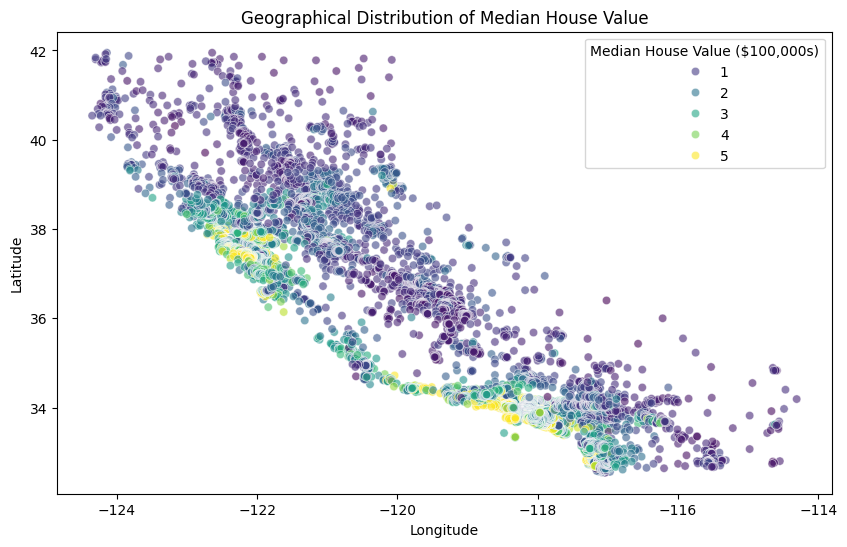

In [7]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue=y,
    data=X,
    palette='viridis',
    alpha=0.6
)
scatter.set_title("Geographical Distribution of Median House Value")
scatter.set_xlabel("Longitude")
scatter.set_ylabel("Latitude")
scatter.legend(title='Median House Value ($100,000s)')
plt.show()

This scatter plot shows the geographical distribution of median house values in California.

We can see how house prices vary across different locations using latitude and longitude. Each point represents a block group, and its color indicates the median house value (in $100,000s). Brighter colors (yellow-green) represent higher house values, while darker colors (purple-blue) show lower values.

From the plot, it’s clear that higher house prices are clustered along the coast, especially around southern California (Los Angeles area) and northern California (San Francisco Bay Area). Inland areas tend to have lower median house values, shown by the dense purple regions. This pattern reflects California’s real-world housing market where coastal cities are more expensive due to demand, jobs, and amenities.

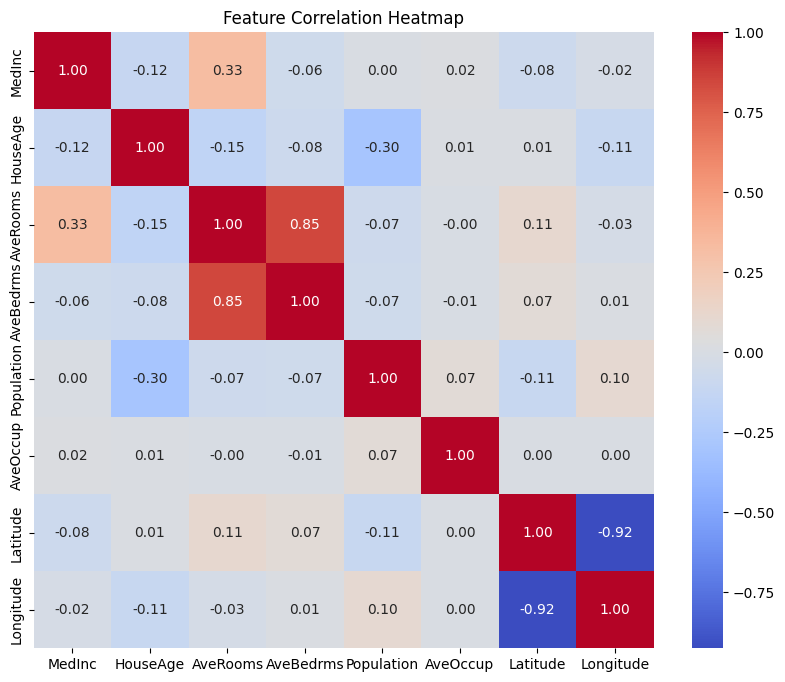

In [8]:
#  Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

From the heatmap, we can see the correlations between the different features in the dataset. Median income shows a positive link with average rooms, meaning higher income areas tend to have larger homes. It has no connection to population size. Older neighborhoods often have smaller populations, which could reflect urban decline or rural aging, and house age doesn’t strongly relate to other features. Average rooms and bedrooms are closely tied, as expected, since larger homes generally have more bedrooms. Latitude and longitude show a strong negative relationship that reflects California’s north-south and east-west geography. Finally, average occupancy appears independent, showing no meaningful connections to other features.


# Step 4: Preprocessing
All features were numerical, so we applied mean imputation and scaling. ColumnTransformer ensures transformations are applied only to the specified columns.

In [9]:
#  Define numeric features
numeric_features = X.columns

#  Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # fill missing values
    ('scaler', StandardScaler())  # standardize
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

# Step 5: Build the Pipeline
The pipeline simplifies workflow by chaining preprocessing and modeling steps.

In [10]:
#  Create pipeline: preprocessing + KNN
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

# Step 6: Hyperparameter Tuning
We tuned n_neighbors, weights, and p (distance metric) using 5-fold cross-validation. R² score was the evaluation metric.

In [11]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define grid
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object'))])),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='r2', verbose=2)

# Step 7: Model Evaluation

In [12]:
# Best model & test performance
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Take square root manually

print("Best Parameters:", grid_search.best_params_)
print("Test R² Score:", r2)
print("Test RMSE:", rmse)

Best Parameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
Test R² Score: 0.72210916268423
Test RMSE: 0.6034489607162036


The best model achieved an R² score of ~0.72, meaning it explains 72% of the variance in house prices.

# Step 8: Save the Model

In [13]:
#  Save pipeline
with open('california_knn_pipeline.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(" Model saved as 'california_knn_pipeline.pkl'")


 Model saved as 'california_knn_pipeline.pkl'


# Step 9: API Deployment

In the final step of the project, we deployed our pre-trained K-Nearest Neighbors (KNN) regression model (california_knn_pipeline.pkl) as an interactive web application.

Using Gradio, we created a simple user interface where anyone can input housing and demographic details—such as median income, house age, number of rooms, population, and location coordinates—and receive an instant prediction of the median house value in California.

This deployment was done directly from Google Colab, allowing us to serve the app with a publicly shareable URL for testing and demonstration purposes.

In [16]:
# Load your saved model
model = joblib.load('california_knn_pipeline.pkl')

# Define prediction function
def predict_price(MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude):
    # Create input DataFrame
    input_data = pd.DataFrame([{
        'MedInc': MedInc,
        'HouseAge': HouseAge,
        'AveRooms': AveRooms,
        'AveBedrms': AveBedrms,
        'Population': Population,
        'AveOccup': AveOccup,
        'Latitude': Latitude,
        'Longitude': Longitude
    }])

    # Make prediction
    prediction = model.predict(input_data)[0] * 100000  # Scale back to dollars
    return f"🏠 Estimated Median House Value: ${prediction:,.2f}"

# Gradio Interface
inputs = [
    gr.Number(label="Median Income (in $10,000s)"),
    gr.Number(label="Median House Age (years)"),
    gr.Number(label="Average Rooms per Household"),
    gr.Number(label="Average Bedrooms per Household"),
    gr.Number(label="Block Group Population"),
    gr.Number(label="Average Occupancy"),
    gr.Number(label="Latitude"),
    gr.Number(label="Longitude"),
]

outputs = gr.Textbox(label="Predicted Median House Value")

# Close any previous Gradio instances (for Colab re-runs)
gr.close_all()

# Launch app (only once)
gr.Interface(
    fn=predict_price,
    inputs=inputs,
    outputs=outputs,
    title="🏡 California Housing Price Predictor",
    description="Enter housing and demographic details to predict the median house value in California.",
    theme="default",
    allow_flagging="never"
).launch(share=True)  # share=True gives a public URL

Closing server running on port: 7860
Closing server running on port: 7861
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://439a40416156331bb9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
